In [ ]:
# 인코딩과 디코딩 

# 인코더는 입력 x 를 잠재 공간 (latent space), 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수
# 디코더는 latent space 요소를 사전 정의된 타겟 도메인으로 매핑하는 함수  

### 오토인코더 
# 입력을 저차원 latent space로 인코딩 한 후 디코딩하여 복원하는 네트워크 
# 이미지를 입력받아 인코더 모듈을 사용하여 latent vector space 로 매핑하고
# 디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

# 원본 입력을 재구성하는 방법으로 학습

In [1]:
# 잠재 공간을 기반으로 손글씨 숫자를 생성하는 것 

from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K
from tensorflow.keras import metrics 
from tensorflow.keras.datasets import mnist 
import numpy as np

In [2]:
# 하이퍼 파라미터 설정 
batch_size = 100
original_dim = 784 
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [4]:
# z_mean과 z_log_var의 연결
# 평균과 표준 편차를 구하는 것 
# z가 샘플링 함수를 통해 z_mean과 z_log_var가 연결 되어 있는것 
def sampling(args : tuple):
  z_mean, z_log_var = args 
  epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = epsilon_std)

  return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
# 함수형 API 
# 인코더 
x = Input(shape=(original_dim,), name = "input") # 인코더 입력 
h = Dense(intermediate_dim, activation='relu', name = 'encoding')(x) # 중간층 
z_mean = Dense(latent_dim, name="mean")(h)            # 잠재 공간의 평균
z_log_var = Dense(latent_dim, name="log-variance")(h) # 잠재 공간의 분산

z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var]) 

encoder = Model(x, [z_mean, z_log_var, z], name="encoder") # 인코더를 정의 

In [6]:
# 디코더 만들기
input_decoder = Input(shape=(latent_dim,), name="decoder_input") #입력
decoder_h = Dense(intermediate_dim, activation='relu', name = "decoder_h")(input_decoder) # latent space를 중간층의 차원으로 변환 
x_decoded = Dense(original_dim, activation = 'sigmoid', name = "flat_decoded")(decoder_h) # 원본 차원으로 변환 

decoder = Model(input_decoder, x_decoded, name = "decoder") 

In [7]:
# 모델 결합 - VAE 만들기 
output_combined = decoder(encoder(x)[2]) # 인코더의 출력을 디코더에 사용, 인코더의 세번째 변환 값이 z다. 

vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 손실 함수 정의 
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis = - 1
)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss = 'binary_crossentropy')

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [14]:
vae.fit(x_train, x_train,
        shuffle = True,
        epochs = epochs,
        batch_size = batch_size)

Epoch 1/50
600/600 [==============================] - 6s 5ms/step - loss: 0.2430
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2166
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2126
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2099
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2080
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2064
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2050
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2036
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2023
Epoch 10/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2012
Epoch 11/50
600/600 [==============================] - 3s 5ms/step - loss: 0.2003
Epoch 12/50
600/600 [==============================] - 3s 6ms/step - loss: 0.1995
Epoch 13/50
600/600 [====

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import norm

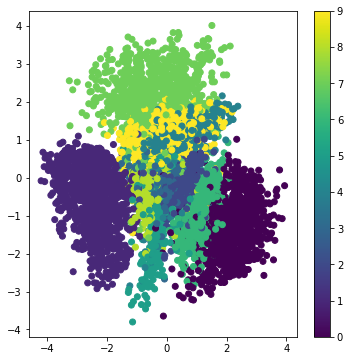

In [18]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

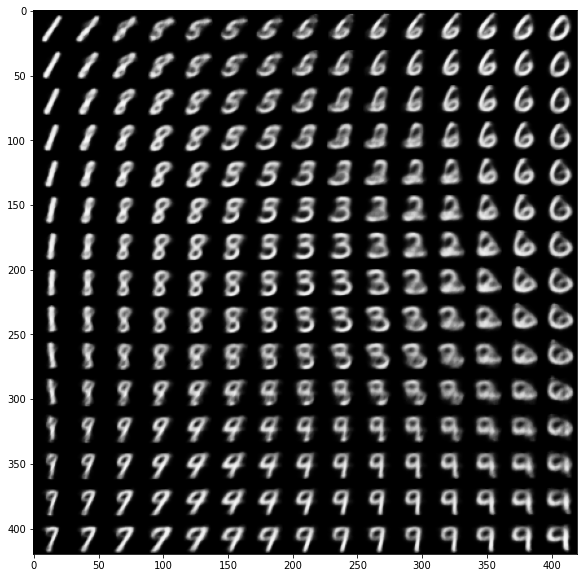

In [21]:

# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()